# Compares monthly met and precipitation statistics with Yang monthly data

Compares monthly met and precipitation statistics calculated from daily NPSNOW data with monthly data from Daqing Yang used in Yang 1999.

In [77]:
%matplotlib inline

In [78]:
import sys
sys.path.append('../source')

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import readers.npsnow as npsnow
from merge_npsnow_data import get_station_list, met_filename, get_precip, plot_station_met, merge_one_station
from constants import DATADIR

## Get list of station id

In [79]:
data_dir = '/home/apbarret/Data/NPSNOW/my_combined_met'
filelist = glob.glob(os.path.join(data_dir, 'npmet_??_combined.csv'))

## Merge met and precip data

In [80]:
def get_merged_data(sid):
    """Loads sub-daily meteorological data and resamples to daily.  Then combined me and precip data into
    a single dataframe.  Tmax, Tmin and wind speed at gauge height are then added
    """
    # Get data
    met = npsnow.read_met(met_filename(sid))
    precDay = get_precip(sid)
    snowDay = get_snowdepth(sid)
    snowDay = snowDay.where(snowDay.notnull(), 0.)
    # Convert to daily metrics
    metDay = met.resample('D').mean()
    metDay['TMIN'] = met['TAIR'].resample('D').min()
    metDay['TMAX'] = met['TAIR'].resample('D').max()
    # Merge data
    df = pd.concat([metDay, precDay, snowDay], axis=1, sort=False)
    df = df.rename({'amount': 'PRECIP', 'type': 'PTYPE', 'snowdepth': 'SDEPTH'}, axis=1)
    df = df.drop('statid', axis=1)  # Drop duplicate column
    # Calculate wind speed at gauge height
    df['Ug'] = df.apply(wind_at_gauge, axis=1)
    return df


def get_snowdepth(sid):
    """Returns snow depth for a given station"""
    snowstk_filename = os.path.join(DATADIR, 'snow', 'measured', 'snwstake.dat')
    snowDay = npsnow.read_snowstake(snowstk_filename)
    return snowDay[snowDay.station == int(sid)].snowdepth

def wind_at_gauge(x):
    """Reduces 10 m wind speed to wind at gauge height orifice"""
    H = 10.  # height of anenometer
    hg = 2.  # height of gauge orifice
    z0 = 0.01  # Roughness parameter of snow surface
    return x.WSPD * np.log10((hg- x.SDEPTH*0.01)/z0) / np.log10(H/z0)


met = npsnow.read_met(met_filename(sid))
np.round(met['1972-05-01'].TAIR.mean(), 1)

## Get daily met and precip data

In [81]:
sid = '13'
df = get_merged_data(sid)
df.head()

,Station_ID,Latitude,Longitude,TAIR,RH,SLP,WDIR,WSPD,TOTCLD,LOWCLD,TSURF,TMIN,TMAX,PRECIP,PTYPE,SDEPTH,Ug
1964-05-01,13.0,NaN,NaN,-22.800,94.00,1024.400,110.0,2.00,8.00,0.000000,NaN,-22.8,-22.8,NaN,NaN,0.0,1.534020
1964-05-02,13.0,73.90000,-167.2760,-18.000,95.50,1021.775,110.0,6.50,7.50,0.000000,NaN,-19.5,-16.0,NaN,NaN,0.0,4.985565
1964-05-03,13.0,73.78925,-167.0530,-15.200,98.50,1020.000,197.5,3.25,6.75,3.333333,NaN,-16.6,-13.7,0.0,1.0,0.0,2.492782
1964-05-04,13.0,74.36950,-166.9865,-20.425,91.50,1031.700,270.0,4.50,3.00,0.000000,NaN,-23.1,-19.5,NaN,NaN,0.0,3.451545
1964-05-05,13.0,74.33250,-166.9780,-18.200,90.25,1026.150,207.5,5.25,5.00,0.000000,NaN,-20.4,-16.1,NaN,NaN,19.0,3.950938


def zscore(x, window=11):
    r = x.rolling(window, center=True)
    m = r.mean()
    s = r.std()
    return (x - m)/s
    

fig, ax = plt.subplots(3, 1, figsize=(12,7))

df[['WSPD', 'Ug']].plot(ax=ax[0])
df.SDEPTH.plot(ax=ax[1])
df.SDEPTH.rolling(11, center=True).mean().plot(ax=ax[1])
#zscore(df.SDEPTH, window=5).plot(ax=ax[2])
rdiff = df.SDEPTH.diff() / df.SDEPTH.rolling(11, center=True).mean()
rdiff.plot(ax=ax[2])

## Convert to monthly data

In [82]:
dfMon = pd.DataFrame({
    'ND': df.Station_ID.resample('MS').count(),
    'NU': df.Ug.resample('MS').count(),
    'Tmn': df.TAIR.resample('MS', label='left').mean(),
    'Ug': df.Ug.resample('MS', label='left').mean(),
    'DP': df.PRECIP[df.PRECIP > 0.].resample('MS').count(),
    'Dtc': df.PRECIP[df.PRECIP == 0.].resample('MS').count(),
    'Pg': df.PRECIP.resample('MS').sum()
})
#dfMon

## Get Yang data

In [85]:
yang_diri = '/home/apbarret/Data/NPSNOW/yang_precip'
yangMon = npsnow.read_yang_updated(os.path.join(yang_diri, f'yang_np_precip_updated_coords_{sid}.csv'))
yangMon.index = yangMon.Date
yangMon

,Date,NP,ND,Tmn,Ug,DP,Dtc,snow%,Pg,windC,traceC,Pc,Lat,Lon
Date,,,,,,,,,,,,,,
1964-05-01,1964-05-01,13.0,30.0,-11.3,4.0,11.0,18.0,94.9,5.9,2.7,1.8,10.4,74.061500,192.186250
1964-06-01,1964-06-01,13.0,30.0,-1.6,3.5,19.0,40.0,55.0,18.9,5.8,4.0,28.7,74.652901,192.315370
1964-07-01,1964-07-01,13.0,31.0,-0.2,3.5,26.0,35.0,36.2,26.0,4.3,3.5,33.8,74.567654,192.994136
1964-08-01,1964-08-01,13.0,31.0,-0.3,3.6,23.0,38.0,43.5,13.1,2.7,3.8,19.6,75.118116,192.440290
1964-09-01,1964-09-01,13.0,30.0,-8.2,3.9,35.0,24.0,100.0,32.2,25.1,2.4,59.7,75.866667,184.782130
1964-10-01,1964-10-01,13.0,31.0,-16.4,3.6,47.0,14.0,100.0,26.0,18.2,1.4,45.6,76.121569,181.556863
1964-11-01,1964-11-01,13.0,30.0,-23.3,4.5,12.0,17.0,100.0,23.1,22.5,1.7,47.3,76.150435,175.970000
1964-12-01,1964-12-01,13.0,31.0,-32.9,3.7,6.0,24.0,100.0,14.4,14.7,2.4,31.5,76.518506,172.569943
1965-01-01,1965-01-01,13.0,31.0,-30.5,4.2,13.0,17.0,100.0,4.9,2.3,1.7,8.9,77.303988,169.820357


## Plot time series

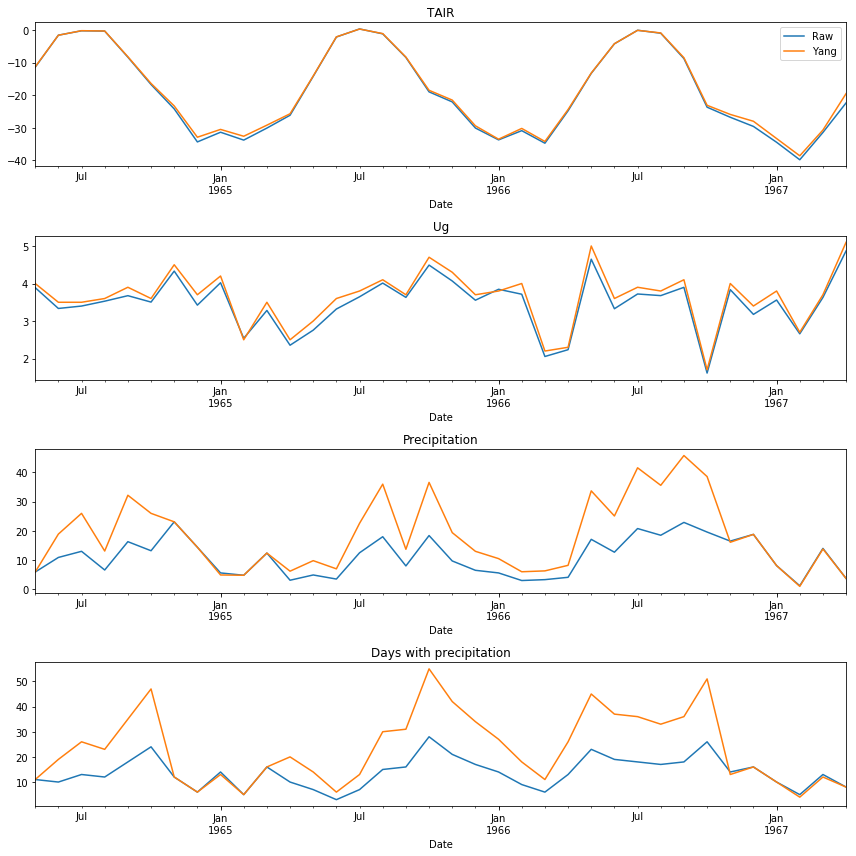

In [84]:
fig, ax = plt.subplots(4, 1, figsize=(12,12))

# Mean temperature
dfMon.Tmn.plot(ax=ax[0], label='Raw')
yangMon.Tmn.plot(ax=ax[0], label='Yang')
ax[0].legend()
ax[0].set_title('TAIR')

# Wind as gauge
dfMon.Ug.plot(ax=ax[1])
yangMon.Ug.plot(ax=ax[1])
ax[1].set_title('Ug')

# Precipitation
dfMon.Pg.plot(ax=ax[2])
yangMon.Pg.plot(ax=ax[2])
ax[2].set_title('Precipitation')

# Days with precipitation and trace
dfMon.DP.plot(ax=ax[3])
yangMon.DP.plot(ax=ax[3])
ax[3].set_title('Days with precipitation')

plt.tight_layout()